<h1 align="center">Check Questions</h1> 

Ответе на вопросы своими словами, если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: В каком пространстве градиентный бустинг совершает градиентный спуск? Какова размерность этого пространства?

<Ответ> в бустинге ставится задача минимизации функции потерь в пространстве алгоритмов. Поэтому размерность пространства - мощность семейства алгоритмов

**Вопрос 2**: Почему бустинг над глубокими деревьями это плохая идея?

<Ответ> Бустинг используется только для неглубоких деревьев, чтобы не переобучаться. Иначе может выялять ненужные выбросы

**Вопрос 3**: Что предсказывает каждое дерево (что является признаками а что целевой переменной?)

<Ответ> Дерево предсказывает класс, к которому относится объект. Соответсвенно, признаки - свойства объекта, целевая переменная - класс

<h1 align="center">Binary Boosting Implementation</h1> 

Давайте вспомним бустинг

#### Градиентный спуск

Самый простой метод минимизации функции, для оптимизации в каждый момент времени двигаемся по антиградиенту функции с каким-то шагом. 

$$w_{n+1} = w_n - s \cdot \frac{\partial f}{\partial w}$$

#### Градиентный бустинг

Теперь давайте представим, что на каждом шаге мы оптимизируем не параметры алгоритма $w$, а ответы нашего алгоритма $\hat{y}$.

**Обучение**: На каждом шаге, давайте предсказывать градиент на каждом объекте и "двигать" ответ в сторону улучшения (антиградиента).

**Алгоритм**:
- Первый алгоритм отвечает константу 
- Добавляем базовые алгоритмы $b_i$, $i = 1, .., N$:
    - $\hat{y} = \sum_{j=0}^{i-1} a_j b_j(x)$
    - Вычисляем градиент функции потерь ПО ОТВЕТАМ модели $g_{i-1} = \frac{\partial L(\hat{y},~~y)}{\partial \hat{y}}$ на каждом объекте  
    - Обучаем $b_i$ предсказывать текущий $g_{i-1}$ (Тут дерево не глубокое регрессионное дерево)
    - Дополняем композицию $\sum_{j=0}^{i-1} a_j b_j (x) + lr * b_i(x)$
    
    
#### Нужно реализовать двух классовый бустинг с логистической функцией потерь.     

**Функция потерь**:
Я вот думаю, что всем интересно какую-же функцию потерь выбрать $\mathcal{L}(\hat{y},y)=\log\left( 1 + e^{-\hat{y}y} \right)$

тут важный момент есть, даже не один
- $\hat{y}$ -- это ответ композиции, тоесть сумма ответов всех предыдущих деревьев
- Это скалярная функция и производная халява, но вот тут мы вам посчитали $$\frac{\partial \mathcal{L}}{\partial \hat{y}} = \frac{1}{1 + e^{-y\hat{y}}} \cdot (-ye^{-y\hat{y}})=-y\frac{1}{1 + e^{y\hat{y}}}$$

In [11]:
%pylab inline

import warnings
import numpy as np
import pandas as pd
from copy import deepcopy
from utils import plot_surface
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from scipy import special

warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
class BinaryBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators, lr=0.1):
        self.lr = lr   
        self.n_estimators = n_estimators
    
    def loss_grad(self, original_y, pred_y):
        return [-y * e for y, e in zip(original_y, special.expit(np.array(original_y) * pred_y))]

    def fit(self, X, original_y):
        self.estimators_ = [] 
        estimator = DecisionTreeRegressor()
        estimator = estimator.fit(X, original_y)
        self.estimators_.append(estimator)
                    
        for i in xrange(1, self.n_estimators):
            grad = self.loss_grad(original_y, self._predict(X))
            estimator = DecisionTreeRegressor()
            estimator = estimator.fit(X, grad)
            self.estimators_.append(estimator)

        return self

    def _predict(self, X):
        y_pred = self.estimators_[0].predict(X)
        for i in xrange(1, len(self.estimators_)):
            y_pred -= self.lr * self.estimators_[i].predict(X)
        return y_pred
    
    def predict(self, X):
        y_pred = []
        for it in self._predict(X):
            if it >= 0: y_pred.append(1)
            else: y_pred.append(-1)
        return y_pred

<h1 align="center">Simple test</h1> 

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
y = 2*(y-0.5)

In [4]:
clf = BinaryBoostingClassifier(n_estimators=100).fit(X[0:900], y[0:900])
print accuracy_score(y[901:1000], clf.predict(X[901:1000]))

clf = GradientBoostingClassifier(n_estimators=100).fit(X[0:900], y[0:900])
print accuracy_score(y[901:1000], clf.predict(X[901:1000]))

0.828282828283
0.868686868687


In [5]:
import os
import numpy as np
import pylab as plt
import numpy as np
from scipy.misc import imread
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surfacec(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array(Z)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

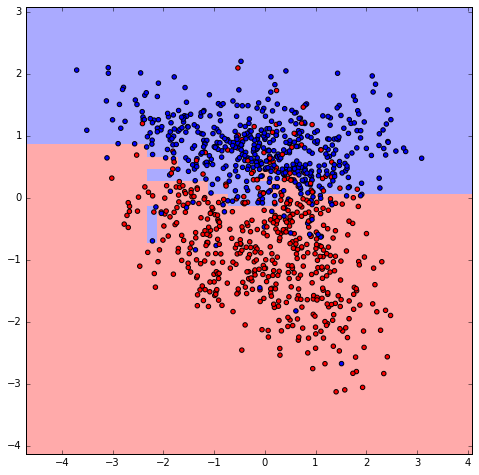

In [6]:
clf = BinaryBoostingClassifier(n_estimators=100).fit(X, y)
plot_surfacec(np.array(X), np.array(y), clf)

<h1 align="center">Adult test</h1> 

#### Скачайте https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [7]:
adult = pd.read_csv(
    './data/adult.data', 
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"], 
    header=None, na_values="?")
adult = pd.get_dummies(adult)
adult["Target"] = adult["Target_ >50K"]

In [8]:
X, y = adult[adult.columns[:-3]].values, adult[adult.columns[-1]].values
y = 2*(y-0.5)

In [9]:
clf = BinaryBoostingClassifier(n_estimators=100).fit(X[0:9000], y[0:9000])
print accuracy_score(y[9001:10000], clf.predict(X[9001:10000]))

clf = GradientBoostingClassifier(n_estimators=100).fit(X[0:9000], y[0:9000])
print accuracy_score(y[9001:10000], clf.predict(X[9001:10000]))



0.807807807808
0.874874874875


<h1 align="center">Сдача ДЗ</h1> 

Заполните форму https://goo.gl/forms/sPE6gpRDNTOXQai12 
    - Качество вашего алгоритма на adult, один знак после запятой, без округления (0.86 -> 0.8 и тд) точность
    - BinaryBoostingClassifier.loss_grad ([-1, 1, 1], [-1, 1, -1]).sum()

In [10]:
def loss_grad(original_y, pred_y):
        return [-y * e for y, e in zip(original_y, special.expit(np.array(original_y) * pred_y))]
    
sum(loss_grad([-1, 1, 1], [-1, 1, -1]))

-0.2689414213699951